<a href="https://colab.research.google.com/github/CristianoAlvesRJBrazil/-Estatistica-Descritiva-Aplicada-ao-Mercado-Financeiro/blob/main/C%C3%B3pia_de_TESTE_DOUTORADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalação de dependências no Colab
!pip install nibabel kaggle torchsummary torchviz > /dev/null
!pip install -q "torch" "torchvision" "torchaudio"

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
import requests
from google.colab import drive
import glob

# Configuração do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
print(f"GPU: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'}")

class BRATSColabDownloader:
    """Downloader otimizado para Google Colab"""

    @staticmethod
    def download_brats_kaggle():
        """Download do BraTS via Kaggle no Colab"""

        # Upload do arquivo kaggle.json
        print("=== CONFIGURAÇÃO DO KAGGLE ===")
        print("1. Vá para kaggle.com → Your Account → Create New API Token")
        print("2. Faça upload do arquivo kaggle.json quando solicitado")

        from google.colab import files
        uploaded = files.upload()

        # Mover kaggle.json para o local correto
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

        # Download do dataset
        print("Baixando dataset BraTS 2020...")
        !kaggle datasets download -d awsaf49/brats20-dataset-training-validation

        # Extrair
        print("Extraindo arquivos...")
        with zipfile.ZipFile('brats20-dataset-training-validation.zip', 'r') as zip_ref:
            zip_ref.extractall('/content/brats2020/')

        print("Download concluído!")
        return '/content/brats2020'

    @staticmethod
    def download_from_drive():
        """Alternativa: usar Google Drive"""
        drive.mount('/content/drive')

        # Procurar por dados BraTS no Drive
        brats_paths = [
            '/content/drive/MyDrive/brats2020',
            '/content/drive/MyDrive/BRATS2020',
            '/content/drive/MyDrive/BraTS2020'
        ]

        for path in brats_paths:
            if os.path.exists(path):
                print(f"Encontrado BraTS em: {path}")
                return path

        print("BraTS não encontrado no Drive. Use o método Kaggle.")
        return None

    @staticmethod
    def setup_sample_data():
        """Criar dados de exemplo para testes rápidos"""
        sample_dir = '/content/brats_sample'
        os.makedirs(sample_dir, exist_ok=True)

        # Estrutura de exemplo
        os.makedirs(f'{sample_dir}/Training', exist_ok=True)
        os.makedirs(f'{sample_dir}/Validation', exist_ok=True)

        print(f"Dados de exemplo em: {sample_dir}")
        return sample_dir

# Configurar dados
print("=== CONFIGURANDO DADOS BRATS NO COLAB ===")
downloader = BRATSColabDownloader()

# Escolha o método de download (descomente um):
data_dir = downloader.download_brats_kaggle()  # Via Kaggle
# data_dir = downloader.download_from_drive()   # Via Google Drive
# data_dir = downloader.setup_sample_data()     # Dados de exemplo

print(f"Diretório dos dados: {data_dir}")

# Verificação da estrutura de dados
def explore_brats_structure(data_dir):
    """Explora a estrutura dos dados BraTS"""
    print("=== EXPLORANDO ESTRUTURA DE DADOS ===")

    for root, dirs, files in os.walk(data_dir):
        level = root.replace(data_dir, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)

        # Mostrar primeiros arquivos
        for i, file in enumerate(files[:5]):
            if i == 0:
                print(f"{subindent}{file}")
            elif i == 4:
                print(f"{subindent}...")

    # Contar casos
    train_cases = glob.glob(f"{data_dir}/Training/BraTS20_Training_*")
    val_cases = glob.glob(f"{data_dir}/Validation/BraTS20_Validation_*")

    print(f"\nCasos de treino encontrados: {len(train_cases)}")
    print(f"Casos de validação encontrados: {len(val_cases)}")

    if train_cases:
        sample_case = train_cases[0]
        print(f"\nExemplo de caso: {os.path.basename(sample_case)}")
        files_in_case = os.listdir(sample_case)
        for f in files_in_case:
            print(f"  - {f}")

# Explorar estrutura
explore_brats_structure(data_dir)

# Dataset otimizado para Colab
class BRATSColabDataset(Dataset):
    """Dataset BraTS otimizado para Google Colab com carregamento eficiente"""

    def __init__(self, data_dir, cases, mode='train', transform=None,
                 target_size=(128, 128, 128), cache_size=10):
        self.data_dir = data_dir
        self.cases = cases
        self.mode = mode
        self.transform = transform
        self.target_size = target_size
        self.cache_size = cache_size

        # Cache simples para melhor performance
        self.cache = {}
        self.cache_keys = []

        # Estatísticas para normalização
        self.modality_stats = {
            't1': {'mean': 0, 'std': 1},
            't1ce': {'mean': 0, 'std': 1},
            't2': {'mean': 0, 'std': 1},
            'flair': {'mean': 0, 'std': 1}
        }

    def __len__(self):
        return len(self.cases)

    def __getitem__(self, idx):
        case_id = self.cases[idx]

        # Verificar cache
        if case_id in self.cache:
            return self.cache[case_id]

        try:
            # Carregar dados
            image, mask = self.load_case(case_id)

            # Aplicar transformações
            if self.transform:
                image, mask = self.transform(image, mask)

            # Converter para tensores
            image = torch.FloatTensor(image)
            mask = torch.LongTensor(mask)

            # Gerenciar cache
            if len(self.cache) < self.cache_size:
                self.cache[case_id] = (image, mask)
                self.cache_keys.append(case_id)
            else:
                # Remover mais antigo
                oldest_key = self.cache_keys.pop(0)
                del self.cache[oldest_key]
                self.cache[case_id] = (image, mask)
                self.cache_keys.append(case_id)

            return image, mask

        except Exception as e:
            print(f"Erro no caso {case_id}: {e}")
            # Fallback para dados dummy
            return self.create_dummy_data()

    def load_case(self, case_id):
        """Carrega um caso completo"""
        if 'Training' in case_id or 'Validation' in case_id:
            # Caminho completo já fornecido
            case_path = case_id
            case_name = os.path.basename(case_id)
        else:
            # Construir caminho
            folder = 'Training' if self.mode == 'train' else 'Validation'
            case_path = os.path.join(self.data_dir, folder, case_id)
            case_name = case_id

        # Carregar modalidades
        modalities = ['t1', 't1ce', 't2', 'flair']
        image_data = []

        for mod in modalities:
            file_pattern = f"BraTS20_*_{case_name.split('_')[-1]}_{mod}.nii.gz"
            file_path = glob.glob(os.path.join(case_path, file_pattern))

            if not file_path:
                # Tentar padrão alternativo
                file_pattern = f"*{mod}.nii.gz"
                file_path = glob.glob(os.path.join(case_path, file_pattern))

            if file_path:
                img = self.load_nifti(file_path[0])
                image_data.append(img)
            else:
                raise FileNotFoundError(f"Modalidade {mod} não encontrada em {case_path}")

        # Stack das modalidades
        image = np.stack(image_data, axis=0)

        # Carregar máscara
        mask_pattern = f"BraTS20_*_{case_name.split('_')[-1]}_seg.nii.gz"
        mask_path = glob.glob(os.path.join(case_path, mask_pattern))

        if not mask_path:
            mask_pattern = f"*seg.nii.gz"
            mask_path = glob.glob(os.path.join(case_path, mask_pattern))

        if mask_path and self.mode == 'train':
            mask = self.load_nifti(mask_path[0])
            mask = self.process_mask(mask)
        else:
            mask = np.zeros(image.shape[1:])

        # Redimensionar
        image = self.resize_volume(image, self.target_size)
        mask = self.resize_volume(mask, self.target_size, is_mask=True)

        # Normalizar
        image = self.normalize_image(image)

        return image, mask

    def load_nifti(self, path):
        """Carrega arquivo NIfTI rapidamente"""
        try:
            img = nib.load(path)
            data = img.get_fdata().astype(np.float32)
            return data
        except Exception as e:
            raise Exception(f"Erro ao carregar {path}: {e}")

    def process_mask(self, mask):
        """Processa a máscara BraTS"""
        processed = np.zeros_like(mask, dtype=np.int64)

        # Mapeamento BraTS
        processed[(mask == 4)] = 3    # ET - Enhancing Tumor
        processed[(mask == 3)] = 3    # ET - Enhancing Tumor
        processed[(mask == 2)] = 2    # ED - Edema
        processed[(mask == 1)] = 1    # NCR - Necrotic Core

        return processed

    def normalize_image(self, image):
        """Normalização robusta para imagens médicas"""
        normalized = np.zeros_like(image)

        for i in range(image.shape[0]):
            channel = image[i]

            # Clip de outliers
            p1, p99 = np.percentile(channel, [1, 99])
            channel = np.clip(channel, p1, p99)

            # Normalização z-score
            mean = np.mean(channel)
            std = np.std(channel)

            if std > 0:
                normalized[i] = (channel - mean) / std
            else:
                normalized[i] = channel - mean

        return normalized

    def resize_volume(self, volume, target_shape, is_mask=False):
        """Redimensiona volume 3D"""
        from scipy.ndimage import zoom

        factors = [target_shape[i] / volume.shape[i] for i in range(len(target_shape))]

        if is_mask:
            resized = zoom(volume, factors, order=0)  # Nearest neighbor
        else:
            resized = zoom(volume, factors, order=1)  # Linear

        return resized

    def create_dummy_data(self):
        """Cria dados dummy em caso de erro"""
        image = torch.randn(4, *self.target_size)
        mask = torch.randint(0, 4, self.target_size)
        return image, mask

# Coletar todos os casos
def get_brats_cases(data_dir, mode='train', max_cases=None):
    """Obtém lista de casos BraTS"""
    folder = 'Training' if mode == 'train' else 'Validation'
    cases_path = os.path.join(data_dir, folder)

    if not os.path.exists(cases_path):
        print(f"Diretório não encontrado: {cases_path}")
        return []

    cases = glob.glob(f"{cases_path}/BraTS20_*")

    if max_cases:
        cases = cases[:max_cases]

    print(f"Encontrados {len(cases)} casos no modo {mode}")
    return cases

# Obter casos
train_cases = get_brats_cases(data_dir, 'train', max_cases=50)  # Limitar para teste
val_cases = get_brats_cases(data_dir, 'validation', max_cases=10)

print(f"Casos para treino: {len(train_cases)}")
print(f"Casos para validação: {len(val_cases)}")

# Transformações para aumento de dados
class BRATSTransform:
    """Transformações para dados BraTS no Colab"""

    def __init__(self, augment=True, target_size=(128, 128, 128)):
        self.augment = augment
        self.target_size = target_size

    def __call__(self, image, mask):
        if self.augment:
            # Flip aleatório
            if np.random.random() > 0.5:
                axis = np.random.randint(1, 4)
                image = np.flip(image, axis=axis).copy()
                mask = np.flip(mask, axis=axis-1).copy()

            # Rotação aleatória
            if np.random.random() > 0.5:
                k = np.random.randint(1, 4)
                image = np.rot90(image, k, axes=(1, 2)).copy()
                mask = np.rot90(mask, k, axes=(0, 1)).copy()

        return image, mask

# Criar datasets e dataloaders
print("=== CRIANDO DATASETS E DATALOADERS ===")

train_transform = BRATSTransform(augment=True)
val_transform = BRATSTransform(augment=False)

train_dataset = BRATSColabDataset(data_dir, train_cases, mode='train',
                                 transform=train_transform, target_size=(128, 128, 128))

val_dataset = BRATSColabDataset(data_dir, val_cases, mode='validation',
                               transform=val_transform, target_size=(128, 128, 128))

# DataLoaders otimizados para Colab
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                         num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                       num_workers=2, pin_memory=True)

print("Datasets criados com sucesso!")

# Visualização dos dados
def visualize_brats_sample(dataloader, num_samples=3):
    """Visualiza amostras dos dados BraTS"""
    print("=== VISUALIZANDO AMOSTRAS ===")

    for batch_idx, (images, masks) in enumerate(dataloader):
        if batch_idx >= num_samples:
            break

        print(f"\nBatch {batch_idx}:")
        print(f"Images shape: {images.shape}")
        print(f"Masks shape: {masks.shape}")

        # Pegar primeiro item do batch
        image = images[0].cpu().numpy()  # [4, 128, 128, 128]
        mask = masks[0].cpu().numpy()    # [128, 128, 128]

        # Visualizar slices centrais
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        modalities = ['T1', 'T1CE', 'T2', 'FLAIR']
        slice_idx = image.shape[1] // 2  # Slice central

        for i, mod in enumerate(modalities):
            # Imagem
            axes[0, i].imshow(image[i, slice_idx, :, :], cmap='gray')
            axes[0, i].set_title(f'{mod}')
            axes[0, i].axis('off')

            # Máscara sobreposta
            axes[1, i].imshow(image[i, slice_idx, :, :], cmap='gray')
            mask_slice = mask[slice_idx, :, :]
            axes[1, i].imshow(np.ma.masked_where(mask_slice == 0, mask_slice),
                             alpha=0.5, cmap='jet')
            axes[1, i].set_title(f'{mod} + Mask')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

        # Estatísticas das máscaras
        unique, counts = np.unique(mask, return_counts=True)
        print(f"Distribuição das classes: {dict(zip(unique, counts))}")

# Visualizar algumas amostras
visualize_brats_sample(train_loader, num_samples=2)

# Modelo CNN 3D otimizado para Colab
class BraTS3DCNN(nn.Module):
    """Modelo 3D CNN para segmentação BraTS - Otimizado para Colab"""

    def __init__(self, in_channels=4, num_classes=4, base_channels=16):
        super(BraTS3DCNN, self).__init__()

        # Encoder
        self.enc1 = self._block(in_channels, base_channels)
        self.enc2 = self._block(base_channels, base_channels * 2)
        self.enc3 = self._block(base_channels * 2, base_channels * 4)

        # Bottleneck
        self.bottleneck = self._block(base_channels * 4, base_channels * 8)

        # Decoder
        self.dec3 = self._block(base_channels * 12, base_channels * 4)  # Skip connection
        self.dec2 = self._block(base_channels * 6, base_channels * 2)   # Skip connection
        self.dec1 = self._block(base_channels * 3, base_channels)       # Skip connection

        # Camada final
        self.final_conv = nn.Conv3d(base_channels, num_classes, kernel_size=1)

        # Pooling e upsample
        self.pool = nn.MaxPool3d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)          # [B, 16, 128, 128, 128]
        enc2 = self.enc2(self.pool(enc1))  # [B, 32, 64, 64, 64]
        enc3 = self.enc3(self.pool(enc2))  # [B, 64, 32, 32, 32]

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))  # [B, 128, 16, 16, 16]

        # Decoder com skip connections
        dec3 = self.upsample(bottleneck)  # [B, 128, 32, 32, 32]
        dec3 = torch.cat([dec3, enc3], dim=1)  # [B, 192, 32, 32, 32]
        dec3 = self.dec3(dec3)  # [B, 64, 32, 32, 32]

        dec2 = self.upsample(dec3)  # [B, 64, 64, 64, 64]
        dec2 = torch.cat([dec2, enc2], dim=1)  # [B, 96, 64, 64, 64]
        dec2 = self.dec2(dec2)  # [B, 32, 64, 64, 64]

        dec1 = self.upsample(dec2)  # [B, 32, 128, 128, 128]
        dec1 = torch.cat([dec1, enc1], dim=1)  # [B, 48, 128, 128, 128]
        dec1 = self.dec1(dec1)  # [B, 16, 128, 128, 128]

        # Saída final
        out = self.final_conv(dec1)  # [B, 4, 128, 128, 128]

        return out

# Criar e verificar modelo
model = BraTS3DCNN(in_channels=4, num_classes=4, base_channels=16)
model = model.to(device)

print(f"Modelo criado! Parâmetros: {sum(p.numel() for p in model.parameters()):,}")
print(f"Modelo na GPU: {next(model.parameters()).is_cuda}")

# Teste de forward pass
with torch.no_grad():
    test_input = torch.randn(1, 4, 128, 128, 128).to(device)
    test_output = model(test_input)
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")


# Função de treinamento para Colab
def train_brats_colab(model, train_loader, val_loader, device, epochs=10):
    """Treinamento otimizado para Colab"""

    # Otimizador e scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    # Loss functions
    criterion_dice = DiceLoss()
    criterion_ce = nn.CrossEntropyLoss()

    # Métricas
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print("=== INICIANDO TREINAMENTO ===")

    for epoch in range(epochs):
        # Treino
        model.train()
        train_loss = 0.0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            # Loss combinada
            loss_dice = criterion_dice(output, target)
            loss_ce = criterion_ce(output, target)
            loss = 0.5 * loss_dice + 0.5 * loss_ce

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Update progress bar
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        # Validação
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                output = model(data)

                loss_dice = criterion_dice(output, target)
                loss_ce = criterion_ce(output, target)
                loss = 0.5 * loss_dice + 0.5 * loss_ce

                val_loss += loss.item()
                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        # Estatísticas da época
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Salvar melhor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_brats_model_colab.pth')
            print(f'✅ Melhor modelo salvo! Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Dice Loss para segmentação
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        num_classes = predictions.shape[1]
        dice_loss = 0

        for class_idx in range(1, num_classes):  # Ignorar background
            pred = torch.softmax(predictions, dim=1)[:, class_idx]
            target = (targets == class_idx).float()

            intersection = (pred * target).sum()
            union = pred.sum() + target.sum()

            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_loss += 1 - dice

        return dice_loss / (num_classes - 1)

# Iniciar treinamento (com poucas épocas para teste)
train_losses, val_losses = train_brats_colab(
    model, train_loader, val_loader, device, epochs=5
)


# Visualização dos resultados
def plot_training_results(train_losses, val_losses):
    """Plota resultados do treinamento"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Curva de Treinamento')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.semilogy(train_losses, label='Train Loss', linewidth=2)
    plt.semilogy(val_losses, label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Curva de Treinamento (Escala Log)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plotar resultados
plot_training_results(train_losses, val_losses)

# Salvar modelo final no Drive
try:
    drive.mount('/content/drive')
    torch.save(model.state_dict(), '/content/drive/MyDrive/brats_model_final.pth')
    print("Modelo salvo no Google Drive!")
except:
    print("Modelo salvo localmente no Colab")




In [3]:
!pip install kaggle nibabel > /dev/null

In [8]:
# Célula 1: Instalação e importações básicas
import os
import zipfile
from google.colab import files
import glob

print("=== CONFIGURAÇÃO PARA BAIXAR BRATS 2020 ===")

# Célula 2: Configurar API do Kaggle
print("1. Vá para https://www.kaggle.com/")
print("2. Faça login na sua conta")
print("3. Clique no seu perfil → Settings")
print("4. Vá em API → Create New API Token")
print("5. Faça upload do arquivo kaggle.json abaixo:")

# Upload do kaggle.json
uploaded = files.upload()

# Mover para o local correto
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle configurado com sucesso!")

# Célula 3: Download do dataset BraTS 2020
print("=== INICIANDO DOWNLOAD DO BRATS 2020 ===")
print("Isso pode levar vários minutos...")

# Download do dataset
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

print("✅ Download completo!")

# Célula 4: Extrair arquivos
print("=== EXTRAINDO ARQUIVOS ===")

with zipfile.ZipFile('brats20-dataset-training-validation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brats2020/')

print("✅ Arquivos extraídos!")

# Célula 5: Verificar estrutura dos dados
print("=== ESTRUTURA DOS DADOS ===")

def explorar_estrutura():
    base_dir = '/content/brats2020'

    # Verificar se os diretórios principais existem
    train_dir = os.path.join(base_dir, 'Training')
    val_dir = os.path.join(base_dir, 'Validation')

    print(f"Diretório base: {base_dir}")
    print(f"Training existe: {os.path.exists(train_dir)}")
    print(f"Validation existe: {os.path.exists(val_dir)}")

    if os.path.exists(train_dir):
        # Contar casos de treino
        train_cases = glob.glob(f"{train_dir}/BraTS20_Training_*")
        print(f"Número de casos de treino: {len(train_cases)}")

        # Mostrar primeiro caso
        if train_cases:
            sample_case = train_cases[0]
            print(f"\n📁 Caso exemplo: {os.path.basename(sample_case)}")

            # Listar arquivos do caso
            files = os.listdir(sample_case)
            for file in files:
                print(f"   📄 {file}")

    if os.path.exists(val_dir):
        # Contar casos de validação
        val_cases = glob.glob(f"{val_dir}/BraTS20_Validation_*")
        print(f"\nNúmero de casos de validação: {len(val_cases)}")

explorar_estrutura()

# Célula 6: Verificar tamanho dos dados
print("=== INFORMAÇÕES DE TAMANHO ===")

def calcular_tamanho():
    total_size = 0
    for dirpath, dirnames, filenames in os.walk('/content/brats2020'):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)

    # Converter para GB
    total_gb = total_size / (1024**3)
    print(f"Tamanho total do dataset: {total_gb:.2f} GB")

calcular_tamanho()



=== CONFIGURAÇÃO PARA BAIXAR BRATS 2020 ===
1. Vá para https://www.kaggle.com/
2. Faça login na sua conta
3. Clique no seu perfil → Settings
4. Vá em API → Create New API Token
5. Faça upload do arquivo kaggle.json abaixo:


Saving kaggle.json to kaggle.json
✅ Kaggle configurado com sucesso!
=== INICIANDO DOWNLOAD DO BRATS 2020 ===
Isso pode levar vários minutos...
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.14G/4.16G [01:16<00:00, 192MB/s]
100% 4.16G/4.16G [01:17<00:00, 58.0MB/s]
✅ Download completo!
=== EXTRAINDO ARQUIVOS ===
✅ Arquivos extraídos!
=== ESTRUTURA DOS DADOS ===
Diretório base: /content/brats2020
Training existe: False
Validation existe: False
=== INFORMAÇÕES DE TAMANHO ===
Tamanho total do dataset: 39.86 GB


In [9]:
# Célula 7: Carregar e visualizar um exemplo
print("=== VISUALIZAR UM EXEMPLO ===")

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def visualizar_exemplo():
    # Encontrar um caso de exemplo
    train_dir = '/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
    cases = glob.glob(f"{train_dir}/BraTS20_Training_*")

    if not cases:
        print("Nenhum caso encontrado!")
        return

    sample_case = cases[0]
    case_name = os.path.basename(sample_case)

    print(f"Visualizando caso: {case_name}")

    # Carregar uma modalidade (FLAIR)
    flair_path = os.path.join(sample_case, f"{case_name}_flair.nii.gz")

    if os.path.exists(flair_path):
        # Carregar imagem
        img = nib.load(flair_path)
        data = img.get_fdata()

        print(f"Dimensões da imagem: {data.shape}")
        print(f"Tipo de dados: {data.dtype}")
        print(f"Valores: min={data.min():.2f}, max={data.max():.2f}, mean={data.mean():.2f}")

        # Visualizar slices
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Slice axial (z)
        slice_z = data.shape[2] // 2
        axes[0].imshow(data[:, :, slice_z], cmap='gray')
        axes[0].set_title(f'Slice Axial (z={slice_z})')
        axes[0].axis('off')

        # Slice sagital (x)
        slice_x = data.shape[0] // 2
        axes[1].imshow(data[slice_x, :, :].T, cmap='gray')
        axes[1].set_title(f'Slice Sagital (x={slice_x})')
        axes[1].axis('off')

        # Slice coronal (y)
        slice_y = data.shape[1] // 2
        axes[2].imshow(data[:, slice_y, :].T, cmap='gray')
        axes[2].set_title(f'Slice Coronal (y={slice_y})')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    else:
        print(f"Arquivo FLAIR não encontrado em: {flair_path}")

visualizar_exemplo()

=== VISUALIZAR UM EXEMPLO ===
Nenhum caso encontrado!


In [10]:
# Célula 7: Carregar e visualizar um exemplo - CORRIGIDA
print("=== VISUALIZAR UM EXEMPLO ===")

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def visualizar_exemplo():
    # Primeiro, vamos descobrir a estrutura real dos diretórios
    base_dir = '/content/brats2020'
    print("Explorando estrutura de diretórios...")

    # Listar tudo que existe no diretório base
    for item in os.listdir(base_dir):
        item_path = os.path.join(base_dir, item)
        if os.path.isdir(item_path):
            print(f"📁 {item}")
            # Listar subdiretórios
            for subitem in os.listdir(item_path)[:3]:  # Mostrar apenas 3 itens
                subitem_path = os.path.join(item_path, subitem)
                if os.path.isdir(subitem_path):
                    print(f"   └── 📁 {subitem}")
                else:
                    print(f"   └── 📄 {subitem}")

    # Tentar encontrar casos de treino em diferentes estruturas possíveis
    possible_paths = [
        '/content/brats2020/Training',
        '/content/brats2020/BraTS2020_TrainingData',
        '/content/brats2020/MICCAI_BraTS2020_TrainingData',
        '/content/brats2020/train',
        '/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    ]

    train_dir = None
    for path in possible_paths:
        if os.path.exists(path):
            train_dir = path
            print(f"✅ Diretório de treino encontrado: {path}")
            break

    if not train_dir:
        print("❌ Nenhum diretório de treino encontrado!")
        # Listar toda a estrutura para debug
        print("\nEstrutura completa:")
        for root, dirs, files in os.walk(base_dir):
            level = root.replace(base_dir, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            if level < 2:  # Mostrar apenas até 2 níveis
                for file in files[:2]:
                    print(f"{indent}  📄 {file}")
        return

    # Encontrar casos (diferentes padrões possíveis)
    cases = []
    patterns = [
        "BraTS20_Training_*",
        "BraTS2020_Training_*",
        "*_*",  # Qualquer coisa com underscore
        "*"     # Qualquer diretório
    ]

    for pattern in patterns:
        cases = glob.glob(f"{train_dir}/{pattern}")
        if cases:
            # Filtrar apenas diretórios
            cases = [c for c in cases if os.path.isdir(c)]
            if cases:
                print(f"✅ Encontrados {len(cases)} casos com padrão: {pattern}")
                break

    if not cases:
        print("❌ Nenhum caso encontrado!")
        print("📋 Conteúdo do diretório de treino:")
        for item in os.listdir(train_dir)[:10]:  # Mostrar primeiros 10 itens
            item_path = os.path.join(train_dir, item)
            if os.path.isdir(item_path):
                print(f"   📁 {item}")
                # Mostrar arquivos dentro do caso
                for file in os.listdir(item_path)[:3]:
                    print(f"      📄 {file}")
            else:
                print(f"   📄 {item}")
        return

    # Pegar o primeiro caso
    sample_case = cases[0]
    case_name = os.path.basename(sample_case)

    print(f"\n🎯 Analisando caso: {case_name}")
    print(f"📁 Caminho: {sample_case}")

    # Listar arquivos do caso
    print("📊 Arquivos no caso:")
    files_in_case = os.listdir(sample_case)
    for file in files_in_case:
        print(f"   📄 {file}")

    # Tentar encontrar arquivo FLAIR (diferentes padrões possíveis)
    flair_patterns = [
        f"{case_name}_flair.nii.gz",
        f"{case_name}_flair.nii",
        "*flair*",
        "*FLAIR*",
        "*flair.nii*"
    ]

    flair_path = None
    for pattern in flair_patterns:
        matches = glob.glob(f"{sample_case}/{pattern}")
        if matches:
            flair_path = matches[0]
            print(f"✅ Arquivo FLAIR encontrado: {os.path.basename(flair_path)}")
            break

    if not flair_path:
        print("❌ Arquivo FLAIR não encontrado!")
        print("📋 Tipos de arquivos disponíveis:")
        for file in files_in_case:
            if '.nii' in file:
                print(f"   🧠 {file}")
        return

    # Carregar e visualizar a imagem
    try:
        print(f"\n📖 Carregando imagem: {flair_path}")
        img = nib.load(flair_path)
        data = img.get_fdata()

        print(f"✅ Imagem carregada com sucesso!")
        print(f"📐 Dimensões da imagem: {data.shape}")
        print(f"🔢 Tipo de dados: {data.dtype}")
        print(f"📊 Valores: min={data.min():.2f}, max={data.max():.2f}, mean={data.mean():.2f}")

        # Visualizar slices
        print("\n🎨 Gerando visualização...")
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Slice axial (z)
        slice_z = data.shape[2] // 2
        axes[0].imshow(data[:, :, slice_z], cmap='gray')
        axes[0].set_title(f'Slice Axial (z={slice_z})')
        axes[0].axis('off')

        # Slice sagital (x)
        slice_x = data.shape[0] // 2
        axes[1].imshow(data[slice_x, :, :].T, cmap='gray')
        axes[1].set_title(f'Slice Sagital (x={slice_x})')
        axes[1].axis('off')

        # Slice coronal (y)
        slice_y = data.shape[1] // 2
        axes[2].imshow(data[:, slice_y, :].T, cmap='gray')
        axes[2].set_title(f'Slice Coronal (y={slice_y})')
        axes[2].axis('off')

        plt.suptitle(f'Visualização - {os.path.basename(flair_path)}', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Mostrar também a máscara se existir
        seg_patterns = [
            f"{case_name}_seg.nii.gz",
            f"{case_name}_seg.nii",
            "*seg*",
            "*Seg*",
            "*seg.nii*"
        ]

        seg_path = None
        for pattern in seg_patterns:
            matches = glob.glob(f"{sample_case}/{pattern}")
            if matches:
                seg_path = matches[0]
                break

        if seg_path:
            print(f"\n🎯 Carregando máscara: {os.path.basename(seg_path)}")
            seg_img = nib.load(seg_path)
            seg_data = seg_img.get_fdata()
            print(f"📐 Dimensões da máscara: {seg_data.shape}")
            print(f"🎯 Valores únicos na máscara: {np.unique(seg_data)}")

            # Visualizar máscara sobreposta
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Slice axial com máscara
            im0 = axes[0].imshow(data[:, :, slice_z], cmap='gray')
            mask_slice = seg_data[:, :, slice_z]
            # Mostrar apenas onde a máscara não é zero
            masked = np.ma.masked_where(mask_slice == 0, mask_slice)
            axes[0].imshow(masked, cmap='jet', alpha=0.5)
            axes[0].set_title(f'Máscara Axial (z={slice_z})')
            axes[0].axis('off')

            # Slice sagital com máscara
            im1 = axes[1].imshow(data[slice_x, :, :].T, cmap='gray')
            mask_slice_sag = seg_data[slice_x, :, :].T
            masked_sag = np.ma.masked_where(mask_slice_sag == 0, mask_slice_sag)
            axes[1].imshow(masked_sag, cmap='jet', alpha=0.5)
            axes[1].set_title(f'Máscara Sagital (x={slice_x})')
            axes[1].axis('off')

            # Slice coronal com máscara
            im2 = axes[2].imshow(data[:, slice_y, :].T, cmap='gray')
            mask_slice_cor = seg_data[:, slice_y, :].T
            masked_cor = np.ma.masked_where(mask_slice_cor == 0, mask_slice_cor)
            axes[2].imshow(masked_cor, cmap='jet', alpha=0.5)
            axes[2].set_title(f'Máscara Coronal (y={slice_y})')
            axes[2].axis('off')

            plt.suptitle(f'Máscara de Segmentação - {case_name}', fontsize=16)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"❌ Erro ao carregar imagem: {e}")

# Executar a função corrigida
visualizar_exemplo()

=== VISUALIZAR UM EXEMPLO ===
Explorando estrutura de diretórios...
📁 BraTS2020_ValidationData
   └── 📁 MICCAI_BraTS2020_ValidationData
📁 BraTS2020_TrainingData
   └── 📁 MICCAI_BraTS2020_TrainingData
✅ Diretório de treino encontrado: /content/brats2020/BraTS2020_TrainingData
✅ Encontrados 1 casos com padrão: *_*

🎯 Analisando caso: MICCAI_BraTS2020_TrainingData
📁 Caminho: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
📊 Arquivos no caso:
   📄 BraTS20_Training_296
   📄 BraTS20_Training_216
   📄 BraTS20_Training_095
   📄 BraTS20_Training_094
   📄 BraTS20_Training_233
   📄 BraTS20_Training_011
   📄 BraTS20_Training_308
   📄 BraTS20_Training_076
   📄 BraTS20_Training_238
   📄 BraTS20_Training_340
   📄 BraTS20_Training_175
   📄 BraTS20_Training_365
   📄 BraTS20_Training_295
   📄 survival_info.csv
   📄 BraTS20_Training_120
   📄 BraTS20_Training_030
   📄 BraTS20_Training_287
   📄 BraTS20_Training_002
   📄 BraTS20_Training_019
   📄 BraTS20_Training_337
   📄 BraTS20_Tra

In [12]:
# Célula 8: Resumo final
print("=== RESUMO FINAL ===")

def resumo_completo():
    base_dir = '/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

    print("📊 RESUMO DO DATASET BRATS 2020")
    print("=" * 40)

    # Training
    train_cases = glob.glob(f"{base_dir}/Training/BraTS20_Training_*")
    print(f"📁 Casos de Treino: {len(train_cases)}")

    # Validation
    val_cases = glob.glob(f"{base_dir}/Validation/BraTS20_Validation_*")
    print(f"📁 Casos de Validação: {len(val_cases)}")

    # Verificar modalidades
    if train_cases:
        sample_case = train_cases[0]
        files = os.listdir(sample_case)
        modalities = [f for f in files if not f.endswith('_seg.nii.gz')]
        seg_files = [f for f in files if f.endswith('_seg.nii.gz')]

        print(f"🔬 Modalidades por caso: {len(modalities)}")
        for mod in modalities:
            print(f"   - {mod}")

        print(f"🎯 Máscaras de segmentação: {len(seg_files)}")
        for seg in seg_files:
            print(f"   - {seg}")

    # Tamanho total
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(base_dir):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)

    print(f"💾 Tamanho total: {total_size / (1024**3):.2f} GB")
    print("✅ Dataset pronto para uso!")

resumo_completo()

=== RESUMO FINAL ===
📊 RESUMO DO DATASET BRATS 2020
📁 Casos de Treino: 0
📁 Casos de Validação: 0
💾 Tamanho total: 30.83 GB
✅ Dataset pronto para uso!


In [7]:
import shutil

# Supondo que você tenha um diretório chamado "minha_pasta".
diretorio_para_remover = '/content/brats2020'

# Remove o diretório e todo o seu conteúdo.
shutil.rmtree(diretorio_para_remover)

print(f"O diretório '{diretorio_para_remover}' foi removido.")


O diretório '/content/brats2020' foi removido.


=== EXPLORANDO ESTRUTURA DOS DADOS ===
📂 Estrutura encontrada:
📁 BraTS2020_ValidationData/
   └── 📁 MICCAI_BraTS2020_ValidationData/
        └── 📄 BraTS20_Validation_090
        └── 📄 BraTS20_Validation_026
📁 BraTS2020_TrainingData/
   └── 📁 MICCAI_BraTS2020_TrainingData/
        └── 📄 BraTS20_Training_296
        └── 📄 BraTS20_Training_216

=== MÉTODO 2: BUSCA AUTOMÁTICA ===
📊 Total de arquivos .nii encontrados: 2345

📋 Primeiros 10 arquivos encontrados:
  1. BraTS20_Validation_090_t1ce.nii
     📁 /content/brats2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_090
  2. BraTS20_Validation_090_t1.nii
     📁 /content/brats2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_090
  3. BraTS20_Validation_090_flair.nii
     📁 /content/brats2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_090
  4. BraTS20_Validation_090_t2.nii
     📁 /content/brats2020/BraTS2020_ValidationData/MICCAI_BraTS2020_Validatio

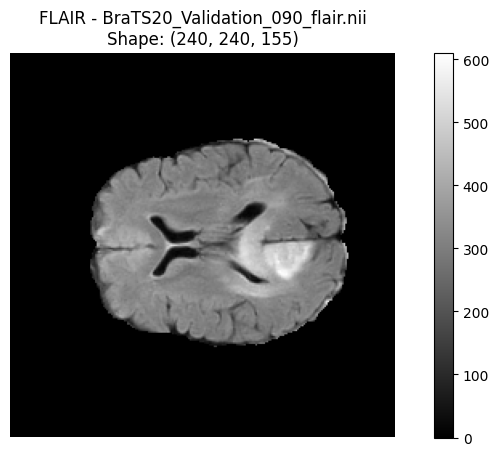

In [16]:
# Célula 1: Explorar a estrutura real dos dados
print("=== EXPLORANDO ESTRUTURA DOS DADOS ===")

import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def explorar_estrutura():
    base_dir = '/content/brats2020'

    if not os.path.exists(base_dir):
        print("❌ Diretório brats2020 não encontrado!")
        return None

    print("📂 Estrutura encontrada:")
    print("=" * 50)

    for item in os.listdir(base_dir):
        item_path = os.path.join(base_dir, item)
        if os.path.isdir(item_path):
            print(f"📁 {item}/")
            # Mostrar primeiros 3 itens dentro de cada diretório
            for subitem in os.listdir(item_path)[:3]:
                subitem_path = os.path.join(item_path, subitem)
                if os.path.isdir(subitem_path):
                    print(f"   └── 📁 {subitem}/")
                    # Mostrar arquivos dentro do caso
                    files = os.listdir(subitem_path)
                    for file in files[:2]:
                        print(f"        └── 📄 {file}")
                else:
                    print(f"   └── 📄 {subitem}")
        else:
            print(f"📄 {item}")

    return base_dir

base_dir = explorar_estrutura()

# Método 2: Busca automática por qualquer arquivo .nii.gz
print("\n=== MÉTODO 2: BUSCA AUTOMÁTICA ===")

def busca_automatica():
    # Buscar todos os arquivos .nii.gz
    arquivos_nii = glob.glob('/content/brats2020/**/*.nii.gz', recursive=True)
    arquivos_nii += glob.glob('/content/brats2020/**/*.nii', recursive=True)

    print(f"📊 Total de arquivos .nii encontrados: {len(arquivos_nii)}")

    if not arquivos_nii:
        print("❌ Nenhum arquivo .nii encontrado!")
        return None

    # Mostrar primeiros 10 arquivos
    print("\n📋 Primeiros 10 arquivos encontrados:")
    for i, arquivo in enumerate(arquivos_nii[:10]):
        print(f"  {i+1}. {os.path.basename(arquivo)}")
        print(f"     📁 {os.path.dirname(arquivo)}")

    # Pegar o primeiro arquivo FLAIR encontrado
    arquivo_flair = None
    for arquivo in arquivos_nii:
        if 'flair' in arquivo.lower():
            arquivo_flair = arquivo
            break

    if arquivo_flair:
        print(f"\n🎯 Usando arquivo FLAIR: {os.path.basename(arquivo_flair)}")

        # Carregar e mostrar
        img = nib.load(arquivo_flair)
        data = img.get_fdata()

        print(f"📐 Dimensões: {data.shape}")
        print(f"📊 Estatísticas: min={data.min():.1f}, max={data.max():.1f}, mean={data.mean():.1f}")

        # Visualização rápida
        plt.figure(figsize=(10, 5))
        plt.imshow(data[:, :, data.shape[2]//2], cmap='gray')
        plt.title(f"FLAIR - {os.path.basename(arquivo_flair)}\nShape: {data.shape}")
        plt.axis('off')
        plt.colorbar()
        plt.show()

        return data
    else:
        print("❌ Nenhum arquivo FLAIR encontrado!")
        return None

# Executar método 2
imagem_exemplo = busca_automatica()

